In [1]:
!pip install captum
!pip install matplotlib==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import collections
from functools import partial


from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

from captum.attr import IntegratedGradients
from captum.attr import GradientShap


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Creating a Data Loader and reading the data

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BASE_PATH = '/kaggle/input/deep-learning-for-msc-2022-23/'

In [4]:
df = pd.read_csv(BASE_PATH + 'train.csv')
df.groupby(['Label']).count()

,Filename
Label,
0,729
1,3462
2,679
3,2690


## The dataset is unevenly distributed, which could make the model biased and neglet one of the classes. Hence I decided to go ahead with an equal number of examples for each class

In [5]:
SAMPLE_SIZE = 650
df_0 = df[df['Label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
df_1 = df[df['Label'] == 1].sample(SAMPLE_SIZE, random_state = 101)
df_2 = df[df['Label'] == 2].sample(SAMPLE_SIZE, random_state = 101)
df_3 = df[df['Label'] == 3].sample(SAMPLE_SIZE, random_state = 101)
df = pd.concat([df_0, df_1, df_2, df_3], axis=0).reset_index(drop=True)
df.groupby(['Label']).count()

,Filename
Label,
0,650
1,650
2,650
3,650


In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

## Split the dataset into training and validation set

In [7]:
y = df['Label']
df_train, df_val = train_test_split(df, test_size=0.10, random_state=101, stratify=y)
train_indices = df_train.index.values.tolist()
val_indices = df_val.index.values.tolist()
print(df_train.shape)
print(df_val.shape)

(2340, 2)
(260, 2)


In [8]:
df_train['Label'].value_counts()

0    585
1    585
3    585
2    585
Name: Label, dtype: int64

In [9]:
class Colon_Cancer_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'Filename'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
#         image = image.resize((100,100))
        label = torch.tensor(self.img_data.loc[index, 'Label'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## Dataloaders fro training and validation set

In [10]:
dataset = Colon_Cancer_Dataset(df,BASE_PATH + 'train/', transform)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                                sampler=valid_sampler)

In [11]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

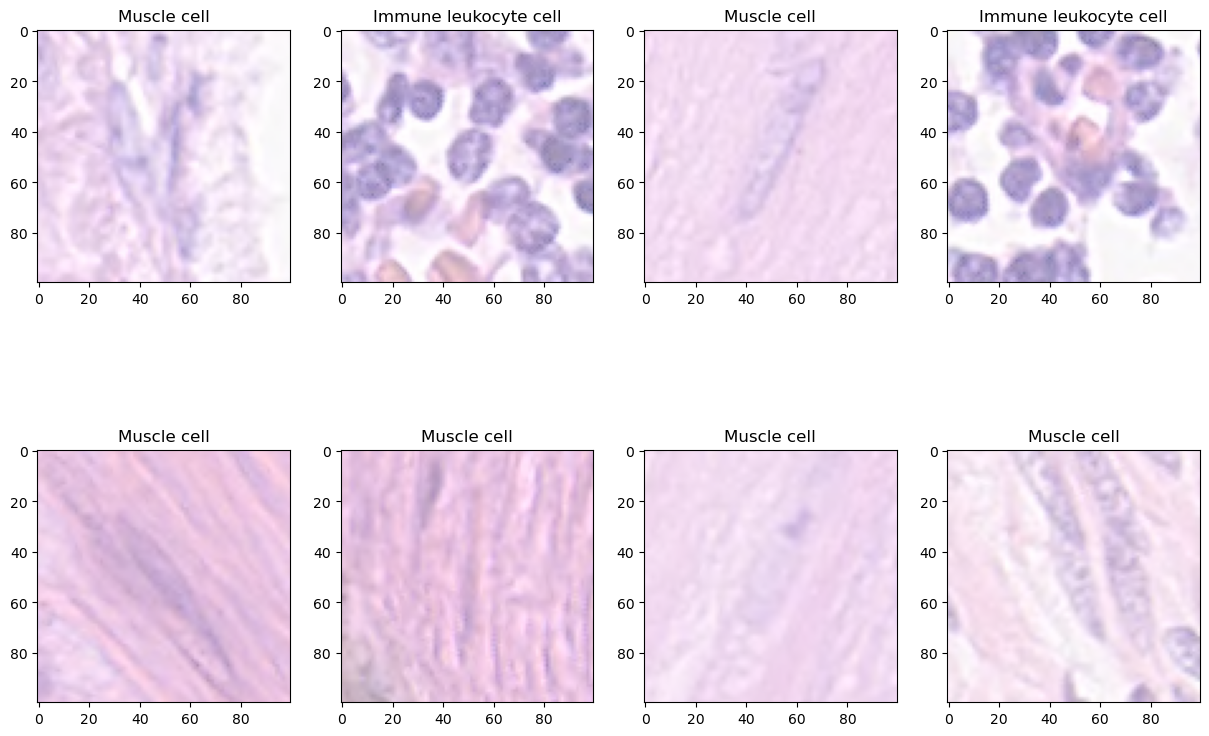

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
arthopod_types = {0: 'Normal epithelial', 1: 'Cancer epithelial', 2: 'Muscle cell', 3: 'Immune leukocyte cell'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

# Model 1

In [13]:
class CancerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            
            nn.Linear(40000, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512, 4)
        )
    
    def forward(self, xb):
        return self.network(xb)

# class BreastCancerCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#         nn.Conv2d(3, 32, kernel_size=3, padding=1),
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2),
            
#         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(128),
#         nn.ReLU(),
# #         nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
# #         nn.BatchNorm2d(128),
# #         nn.ReLU(),
#         nn.MaxPool2d(2, 2),
            
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2),
            
#         nn.Flatten(),
#         nn.Linear(1024*6*6, 1024),
#         nn.ReLU(),
#         nn.Linear(1024, 512),
#         nn.ReLU(),
#         nn.Linear(512, 4)
#         )
    
#     def forward(self, xb):
#         return self.network(xb)

In [14]:
import datetime

"""
This module defines a training loop for a PyTorch model. It includes functions for training and testing the model, as well as saving checkpoints for the model state and optimizer state at each epoch. The training loop takes as input the number of epochs to run, the model to train, the device to run on, the loss function, the training and test data loaders, and the directory to save checkpoints.

Functions:

training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, test_loader, checkpoint_dir): trains the model for the specified number of epochs, updating the model and optimizer parameters based on the loss function and training data. Calls test_loop at the end of each epoch to evaluate the model on the test data. Saves a checkpoint for the model state and optimizer state at the end of each epoch.

test_loop(model, device, test_loader): evaluates the model on the test data, calculating the average loss and accuracy of the predictions. Reports these metrics using the Tune library.

Variables:

epoch_print_gap: controls how often to print updates during training
total_step: the total number of steps in the training data
val_loss: a list to store the validation loss at each epoch
val_acc: a list to store the validation accuracy at each epoch
train_loss: a list to store the training loss at each epoch
train_acc: a list to store the training accuracy at each epoch
preds: a list to store the predicted labels for each test image
"""

epoch_print_gap = 1
total_step = len(train_loader)
val_loss = []
val_acc = []
train_loss = []
train_acc = []
preds = []

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, test_loader, checkpoint_dir):
    val_loss.clear()
    val_acc.clear()
    train_loss.clear()
    train_acc.clear()
    model = model.to(device)
    for epoch in range(1, n_epochs + 1):
        correct = 0
        count = 0
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            labels = labels.to(device)
            loss = loss_fn(outputs, labels)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
            count += len(labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        test_loop(model, device, test_loader)
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
        train_acc.append(100 * correct / count)
        train_loss.append(loss_train/total_step)
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

def test_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            preds.extend(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(labels)
    test_loss /= count

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, count,
        100. * correct / count))
    val_acc.append(100. * correct / count)
    val_loss.append(test_loss)
    tune.report(loss=test_loss, accuracy=correct / count)

In [15]:
def train_cifar(config, data, checkpoint_dir=None, data_dir=None):
    model = CancerCNN()
    use_cuda = True
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    model = model.to(device)
    n_epochs = 5
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    loss_fn = nn.CrossEntropyLoss()
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    dataset = Colon_Cancer_Dataset(data,data_dir, transform)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=int(config["batch_size"]), 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=int(config["batch_size"]),
                                                sampler=valid_sampler)

    training_loop(
        n_epochs = n_epochs, 
        optimizer = optimizer,
        model = model, 
        device = device,
        loss_fn = loss_fn,
        train_loader = train_loader,
        test_loader = validation_loader,
        checkpoint_dir = checkpoint_dir
    )

In [16]:
config = {
    "lr": tune.loguniform(1e-5, 1e-4),
    "batch_size": tune.choice([2, 4, 8, 16])
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_cifar,data=df, data_dir=BASE_PATH + 'train/'),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=scheduler,
    progress_reporter=reporter)

2023-03-27 12:27:37,260	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0327 12:27:40.567719274      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 12:27:41 (running for 00:00:00.40)
Memory usage on this node: 1.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar_2023-03-27_12-27-40
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+-------------+
| Trial name              | status   | loc            |   batch_size |          lr |
|-------------------------+----------+----------------+--------------+-------------|
| train_cifar_c4250_00000 | RUNNING  | 172.19.2.2:316 |           16 | 2.15726e-05 |
| train_cifar_c4250_00001 | PENDING  |                |            8 | 3.96425e-05 |
| train_cifar_c4250_00002 | PENDING  |                |            2 | 3.63754e-05 |
| train_cifar_c4250_00003 | 

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar_c4250_00000,0.294118,2023-03-27_12-28-35,True,,43e4a68714bc4af283eb6325145518ab,bf8bbac96a5e,5,0.631741,172.19.2.2,316,49.8664,6.338,49.8664,1679920115,0,,5,c4250_00000,0.00622988
train_cifar_c4250_00001,0.182765,2023-03-27_12-29-20,True,,617d5f08466241f1b493684a9b01b905,bf8bbac96a5e,5,0.262361,172.19.2.2,413,38.513,6.7727,38.513,1679920160,0,,5,c4250_00001,0.00461006
train_cifar_c4250_00002,0.0475962,2023-03-27_12-30-25,True,,5ce490f3261444a58b7573fea1643327,bf8bbac96a5e,5,0.0417949,172.19.2.2,497,60.4128,11.1504,60.4128,1679920225,0,,5,c4250_00002,0.00493312
train_cifar_c4250_00003,0.0932692,2023-03-27_12-31-16,True,,11e8f250ae094739b7c99eb0b31325a9,bf8bbac96a5e,5,0.0740073,172.19.2.2,600,45.1906,8.86947,45.1906,1679920276,0,,5,c4250_00003,0.00496531
train_cifar_c4250_00004,0.167279,2023-03-27_12-31-31,True,,86e6b30239a241eb89293018373945c7,bf8bbac96a5e,1,0.647018,172.19.2.2,686,8.81781,8.81781,8.81781,1679920291,0,,1,c4250_00004,0.00736499
train_cifar_c4250_00005,0.0975962,2023-03-27_12-32-21,True,,e1c2810de89e4c25ab991e369d16d744,bf8bbac96a5e,5,0.0912128,172.19.2.2,742,44.8384,8.38898,44.8384,1679920341,0,,5,c4250_00005,0.00448895
train_cifar_c4250_00006,0.0980769,2023-03-27_12-33-11,True,,f9c89e64842b4035b9e7feae1c2c6f84,bf8bbac96a5e,5,0.0698517,172.19.2.2,828,44.9505,8.14308,44.9505,1679920391,0,,5,c4250_00006,0.00508142
train_cifar_c4250_00007,0.05,2023-03-27_12-34-19,True,,438d50f365f04e5c9003f5cb02a2f28b,bf8bbac96a5e,5,0.0309034,172.19.2.2,922,61.5976,11.366,61.5976,1679920459,0,,5,c4250_00007,0.0054493
train_cifar_c4250_00008,0.0807692,2023-03-27_12-34-37,True,,2d688c0189544ae08b8f9655ff4a87bd,bf8bbac96a5e,1,0.160512,172.19.2.2,1024,12.3446,12.3446,12.3446,1679920477,0,,1,c4250_00008,0.00460625
train_cifar_c4250_00009,0.174632,2023-03-27_12-34-51,True,,ee8a4474be7e4dc79bd1a3b561bc2cd8,bf8bbac96a5e,1,0.652714,172.19.2.2,1082,9.19866,9.19866,9.19866,1679920491,0,,1,c4250_00009,0.00652814


(func pid=316) 
(func pid=316) Test set: Average loss: 0.6557, Accuracy: 86/544 (16%)
(func pid=316) 
(func pid=316) 2023-03-27 12:28:11.646726 Epoch 1, Training loss 202.4380099773407
== Status ==
Current time: 2023-03-27 12:28:16 (running for 00:00:35.86)
Memory usage on this node: 3.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6557463775662815
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar_2023-03-27_12-27-40
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+-------------+----------+------------+----------------------+
| Trial name              | status   | loc            |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|-------------------------+----------+----------------+--------------+----

2023-03-27 12:34:51,848	INFO tune.py:763 -- Total run time: 431.32 seconds (430.94 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 12:34:51 (running for 00:07:10.95)
Memory usage on this node: 3.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.07847228692128108 | Iter 2.000: -0.11165199337097315 | Iter 1.000: -0.16092644012891327
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar_2023-03-27_12-27-40
Number of trials: 10/10 (10 TERMINATED)
+-------------------------+------------+-----------------+--------------+-------------+-----------+------------+----------------------+
| Trial name              | status     | loc             |   batch_size |          lr |      loss |   accuracy |   training_iteration |
|-------------------------+------------+-----------------+--------------+-------------+-----------+------------+----------------------|
| train_cifar_c4250_00000 | TERMINATED | 172.19.2.2:316  |           16 | 2.15726e-05 | 0.631

## Each hyperparameter is run only for 5 epochs so that a baseline model is found which performs the best, once found, I run that on more epochs to improve accuracy

In [17]:
def test_accuracy(net, device="cpu"):
    dataset = Colon_Cancer_Dataset(df,BASE_PATH + 'train/', transform)
    valid_sampler = SubsetRandomSampler(val_indices)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                                sampler=valid_sampler)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [18]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = CancerCNN()
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

test_acc = test_accuracy(best_trained_model, device)
print("Best trial test set accuracy: {}".format(test_acc))

Best trial config: {'lr': 6.696036005534379e-05, 'batch_size': 2}
Best trial final validation loss: 0.03090335429341604
Best trial final validation accuracy: 0.05
Best trial test set accuracy: 0.5692307692307692


## The best model is now run to get a higher accuracy

In [19]:
best_trained_model.load_state_dict(model_state)
n_epochs = 25
optimizer = optim.SGD(best_trained_model.parameters(), lr=best_trial.config['lr'])
optimizer.load_state_dict(optimizer_state)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=best_trial.config['batch_size'], 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=best_trial.config['batch_size'],
                                                sampler=valid_sampler)
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
best_trained_model.to(device)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = best_trained_model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
    test_loader = validation_loader,
    checkpoint_dir='test'
)


Test set: Average loss: 0.0354, Accuracy: 216/4160 (5%)



2023-03-27 12:35:07,826	WARNING session.py:93 -- Session not detected. You should not be calling `report` outside `tuner.fit()` or while using the class API. 
2023-03-27 12:35:07,828	WARNING session.py:96 --   File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_o

2023-03-27 12:35:07.829398 Epoch 1, Training loss 898.289150826633

Test set: Average loss: 0.0311, Accuracy: 208/4160 (5%)

2023-03-27 12:35:19.154275 Epoch 2, Training loss 535.3278340464458

Test set: Average loss: 0.0294, Accuracy: 211/4160 (5%)

2023-03-27 12:35:30.532692 Epoch 3, Training loss 486.1940041206544

Test set: Average loss: 0.0365, Accuracy: 200/4160 (5%)

2023-03-27 12:35:41.758172 Epoch 4, Training loss 455.17577187763527

Test set: Average loss: 0.0261, Accuracy: 217/4160 (5%)

2023-03-27 12:35:52.954548 Epoch 5, Training loss 424.7569604795426

Test set: Average loss: 0.0260, Accuracy: 211/4160 (5%)

2023-03-27 12:36:04.378088 Epoch 6, Training loss 405.48998527554795

Test set: Average loss: 0.0260, Accuracy: 209/4160 (5%)

2023-03-27 12:36:15.723757 Epoch 7, Training loss 382.94508937558567

Test set: Average loss: 0.0274, Accuracy: 215/4160 (5%)

2023-03-27 12:36:27.153208 Epoch 8, Training loss 361.6781653916405

Test set: Average loss: 0.0275, Accuracy: 209/4

## Loss and Accuracy curves of the best model

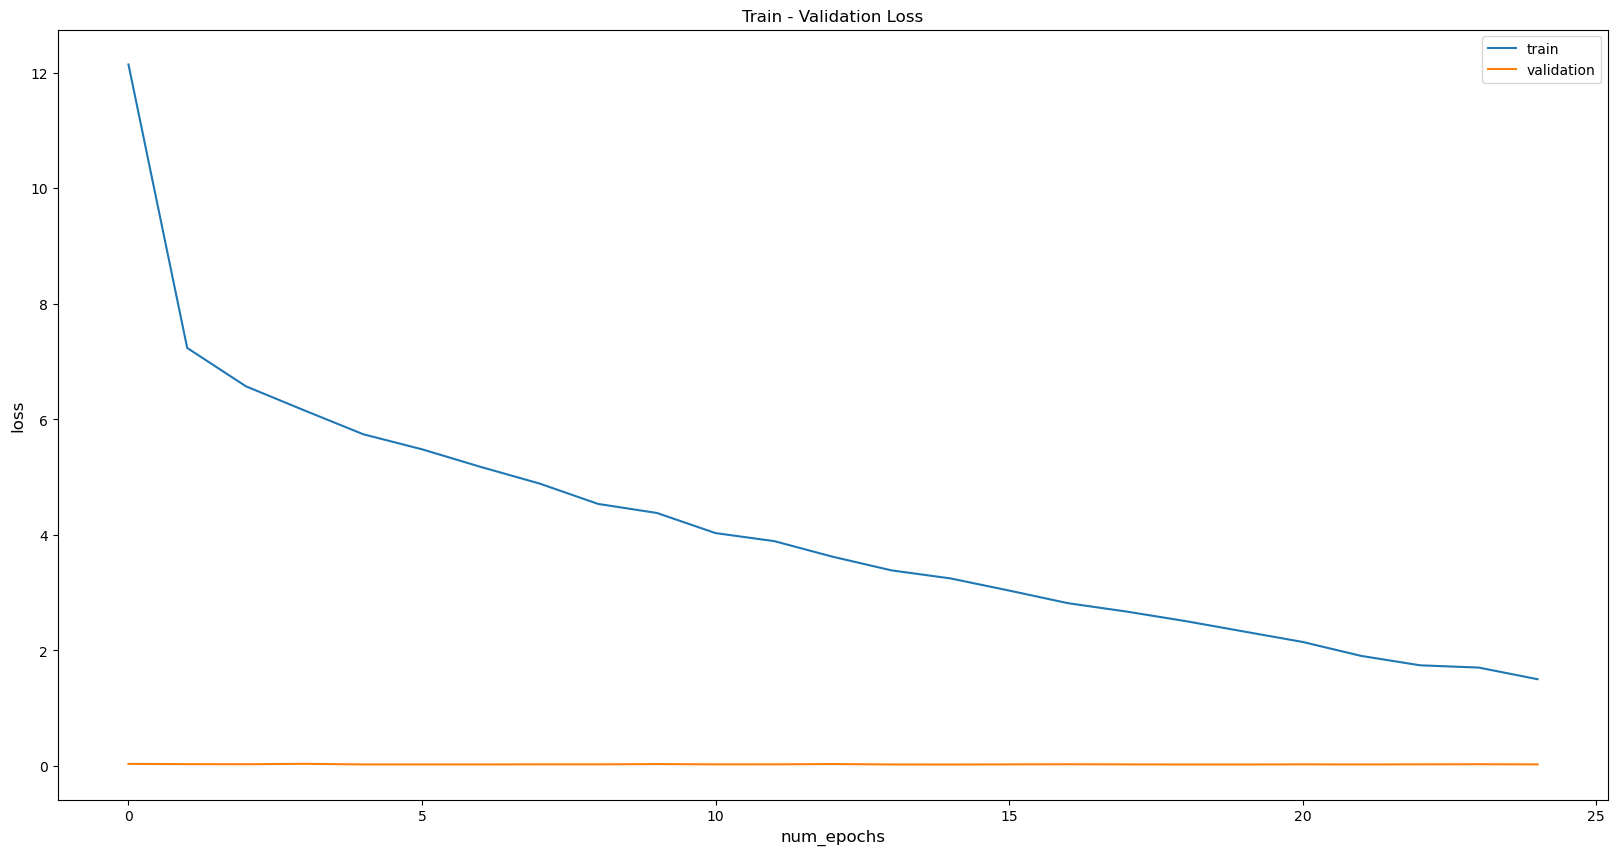

In [20]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

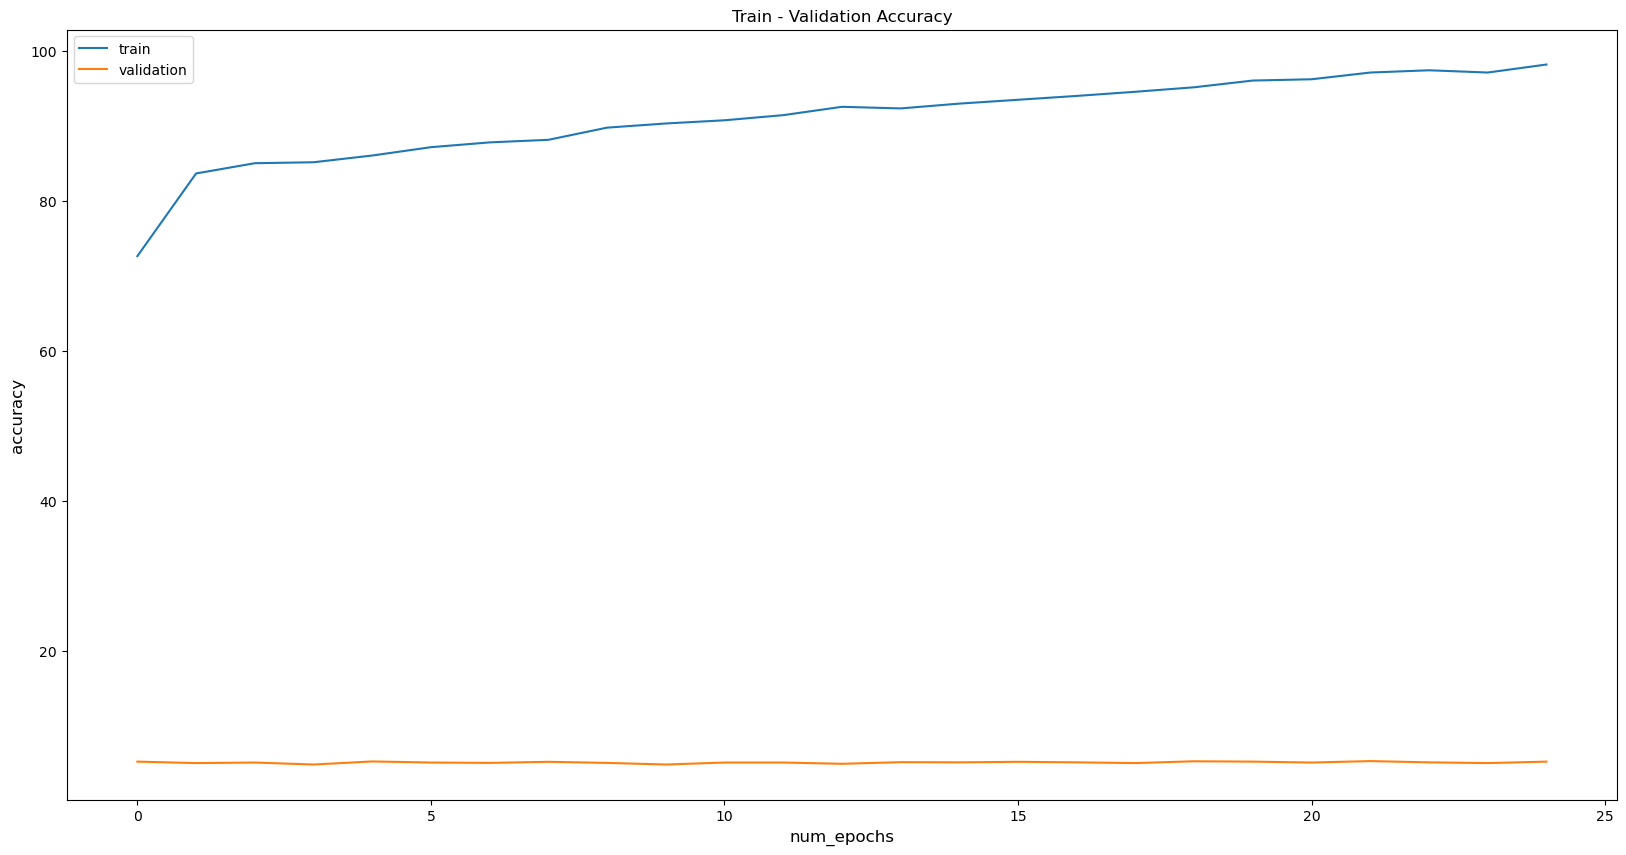

In [21]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

## Confusion matrix

In [22]:
predicted_y_valid = []
for p in preds:
    predicted_y_valid.append(p.item())

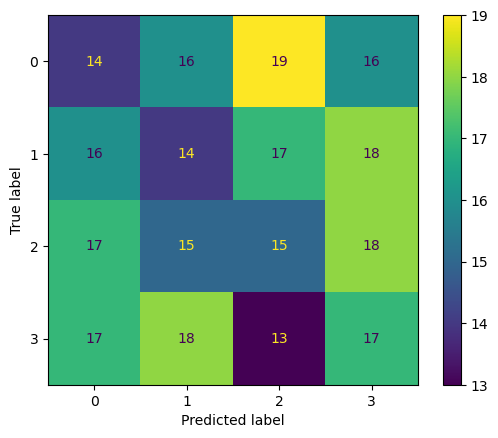

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(df.iloc[val_indices]['Label'].tolist(), predicted_y_valid[-260:])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Captum interpretation

In [24]:
sample_image = None
sample_label = None
for test_images, test_labels in train_loader:  
    sample_image = test_images[0]
    sample_label = test_labels[0]
    break

In [25]:
sample_image = sample_image.to(device)
input = sample_image.unsqueeze(0)
output = best_trained_model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

# print(pred_label_idx, prediction_score)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')', sample_label)

Predicted: tensor(2, device='cuda:0') ( 0.9954517483711243 ) tensor(2)


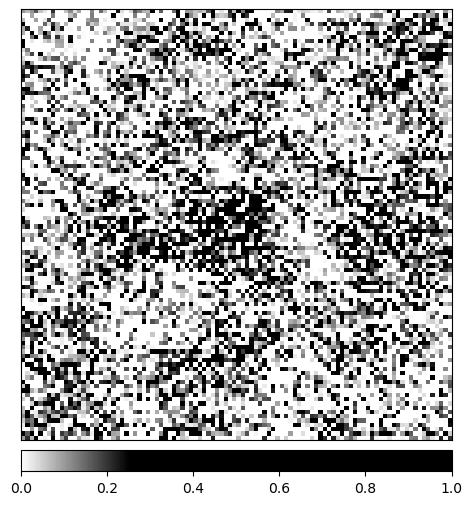

In [26]:
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

integrated_gradients = IntegratedGradients(best_trained_model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

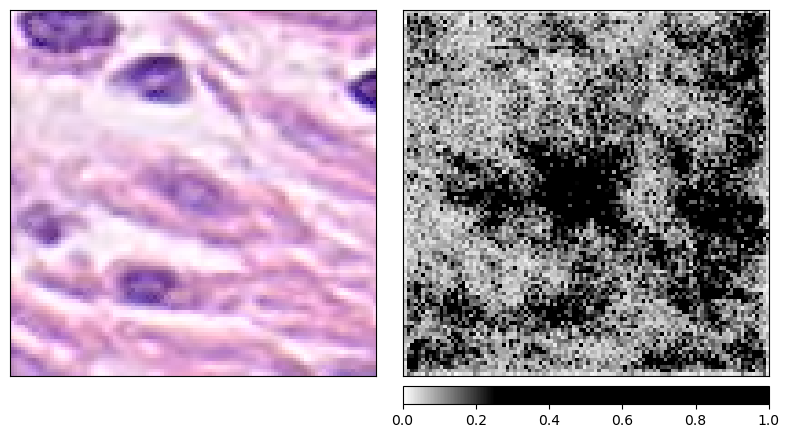

In [27]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(sample_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


# **Model 2**

In [28]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [29]:
import time
import copy
val_loss = []
val_acc = []
train_loss = []
train_acc = []

"""
This function trains a PyTorch model on a given dataset, using a specified criterion and optimizer.
The model is trained for a fixed number of epochs, and the best model weights based on validation accuracy are saved.

Parameters:
- model: The PyTorch model to be trained.
- criterion: The loss function to be optimized during training.
- optimizer: The optimizer used to update the model parameters.
- train_loader: A DataLoader object containing the training dataset.
- validation_loader: A DataLoader object containing the validation dataset.
- checkpoint_dir: The directory to save checkpoints of the model during training.
- device: The device on which to run the training (e.g. 'cuda' for GPU or 'cpu' for CPU).
- num_epochs: The number of epochs to train the model (default=25).

Returns:
- The trained PyTorch model, with the best model weights based on validation accuracy loaded.

During training, the function prints out the loss and accuracy for each epoch and phase (training or validation).
At the end of each epoch, the function saves a checkpoint of the model weights to the specified checkpoint directory,
and reports the loss and accuracy to Ray Tune for hyperparameter tuning purposes.
"""

def train_model(model, criterion, optimizer, train_loader, validation_loader,checkpoint_dir,device, batch_size, num_epochs=25):
    since = time.time()
    val_loss.clear()
    val_acc.clear()
    train_loss.clear()
    train_acc.clear()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            loader = train_loader
            if phase == 'val':
                loader = validation_loader
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / (len(loader)*batch_size)
            epoch_acc = running_corrects.double() / (len(loader)*batch_size)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())
                print(epoch_acc.item())
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        tune.report(loss=epoch_loss, accuracy=epoch_acc.item())
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
def train_cifar2(config, data, checkpoint_dir=None, data_dir=None):
    resnet = models.resnet18(pretrained=True)
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_ftrs, 4)
    use_cuda = True
    device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    resnet = resnet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        resnet.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    dataset = Colon_Cancer_Dataset(data,data_dir, transform)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=int(config["batch_size"]), 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=int(config["batch_size"]),
                                                sampler=valid_sampler)

    resnet = train_model(resnet, criterion, optimizer, train_loader, validation_loader,checkpoint_dir, device, config["batch_size"], num_epochs=5)

In [31]:
config = {
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": tune.choice([2, 4, 8])
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(
    metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_cifar2,data=df, data_dir=BASE_PATH + 'train/'),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=15,
    scheduler=scheduler,
    progress_reporter=reporter)

== Status ==
Current time: 2023-03-27 12:39:45 (running for 00:00:00.27)
Memory usage on this node: 3.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------+--------------+-------------+
| Trial name               | status   | loc             |   batch_size |          lr |
|--------------------------+----------+-----------------+--------------+-------------|
| train_cifar2_742f3_00000 | RUNNING  | 172.19.2.2:1360 |            2 | 7.62798e-05 |
| train_cifar2_742f3_00001 | PENDING  |                 |            2 | 0.000346739 |
| train_cifar2_742f3_00002 | PENDING  |                 |            4 | 0.000949898 |
| train_cifar2

(func pid=1360) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1360)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1360) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1360)   warnings.warn(msg)


(func pid=1360) Epoch 0/4
(func pid=1360) ----------
== Status ==
Current time: 2023-03-27 12:39:55 (running for 00:00:09.74)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------+--------------+-------------+
| Trial name               | status   | loc             |   batch_size |          lr |
|--------------------------+----------+-----------------+--------------+-------------|
| train_cifar2_742f3_00000 | RUNNING  | 172.19.2.2:1360 |            2 | 7.62798e-05 |
| train_cifar2_742f3_00001 | PENDING  |                 |            2 | 0.000346739 |
| train_cifar2_742f3_00002 | PENDING  |         

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_cifar2_742f3_00000,0.657692,2023-03-27_12-41-32,True,,5b7567e6612d4b9e826894b69d333215,bf8bbac96a5e,5,0.834537,172.19.2.2,1360,102.228,20.1795,102.228,1679920892,0,,5,742f3_00000,0.00544763
train_cifar2_742f3_00001,0.8,2023-03-27_12-43-22,True,,32d6da47c2d642e38a4825eddcbc6cc9,bf8bbac96a5e,5,0.624689,172.19.2.2,1500,104.161,19.9073,104.161,1679921002,0,,5,742f3_00001,0.00521636
train_cifar2_742f3_00002,0.888462,2023-03-27_12-44-33,True,,77dcdd76501a47f18c8df4d84fe326ca,bf8bbac96a5e,5,0.303697,172.19.2.2,1646,65.4358,13.1744,65.4358,1679921073,0,,5,742f3_00002,0.00460029
train_cifar2_742f3_00003,0.411538,2023-03-27_12-44-54,True,,ded6c8bf91a84c118e8ba6098ceed82c,bf8bbac96a5e,1,1.27529,172.19.2.2,1765,15.6233,15.6233,15.6233,1679921094,0,,1,742f3_00003,0.00577092
train_cifar2_742f3_00004,0.269231,2023-03-27_12-45-16,True,,29cb2a649c3545569b5d53704f0f8b69,bf8bbac96a5e,1,1.48679,172.19.2.2,1827,16.5377,16.5377,16.5377,1679921116,0,,1,742f3_00004,0.00469708
train_cifar2_742f3_00005,0.330769,2023-03-27_12-45-46,True,,4903f59217e74948ae86ecea8c94c3cb,bf8bbac96a5e,1,1.44652,172.19.2.2,1888,24.9917,24.9917,24.9917,1679921146,0,,1,742f3_00005,0.00521064
train_cifar2_742f3_00006,0.314394,2023-03-27_12-46-04,True,,adeab3e04e984f788c889562df52bfe1,bf8bbac96a5e,1,1.44961,172.19.2.2,1952,12.1386,12.1386,12.1386,1679921164,0,,1,742f3_00006,0.00521207
train_cifar2_742f3_00007,0.688462,2023-03-27_12-46-52,True,,45bf37a85e444a74918105ba3a2de748,bf8bbac96a5e,2,0.831989,172.19.2.2,2012,43.6281,20.1656,43.6281,1679921212,0,,2,742f3_00007,0.00482893
train_cifar2_742f3_00008,0.696154,2023-03-27_12-47-26,True,,fb43ca12c8924fd187c446d718b9f5c6,bf8bbac96a5e,2,0.817396,172.19.2.2,2093,28.2331,12.2996,28.2331,1679921246,0,,2,742f3_00008,0.00584531
train_cifar2_742f3_00009,0.492308,2023-03-27_12-47-55,True,,27b3e6f2b1f0499aa116eaaa335af935,bf8bbac96a5e,1,1.20985,172.19.2.2,2176,23.7365,23.7365,23.7365,1679921275,0,,1,742f3_00009,0.00552487


(func pid=1360) 
(func pid=1360) Epoch 1/4
(func pid=1360) ----------
== Status ==
Current time: 2023-03-27 12:40:18 (running for 00:00:32.69)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -1.1863451923315342
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------+--------------+-------------+---------+------------+----------------------+
| Trial name               | status   | loc             |   batch_size |          lr |    loss |   accuracy |   training_iteration |
|--------------------------+----------+-----------------+--------------+-------------+---------+------------+----------------------|
| train_cifar2_742f3_00000 | RUNNING  | 172.19.2.2:1

(func pid=1500) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1500)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1500) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1500)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:41:38 (running for 00:01:52.65)
Memory usage on this node: 3.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.8607058410461133 | Iter 2.000: -1.0142655663765394 | Iter 1.000: -1.1863451923315342
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (13 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00001 | RUNNING    | 172.19.2.2:1500 |          

(func pid=1646) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1646)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1646) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1646)   warnings.warn(msg)


(func pid=1646) Epoch 0/4
(func pid=1646) ----------
== Status ==
Current time: 2023-03-27 12:43:33 (running for 00:03:47.78)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.7438268265239179 | Iter 2.000: -0.8706799152951974 | Iter 1.000: -1.0605890096953283
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_7

(func pid=1765) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1765)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1765) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1765)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:44:39 (running for 00:04:53.68)
Memory usage on this node: 3.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7270942642138555 | Iter 1.000: -0.9348328270591222
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00003 | RUNNING    | 172.19.2.2:1765 |          

(func pid=1827) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1827)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1827) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1827)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:45:00 (running for 00:05:14.68)
Memory usage on this node: 3.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7270942642138555 | Iter 1.000: -1.0605890096953283
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00004 | RUNNING    | 172.19.2.2:1827 |          

(func pid=1888) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1888)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1888) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1888)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:45:22 (running for 00:05:36.69)
Memory usage on this node: 3.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7270942642138555 | Iter 1.000: -1.1863451923315342
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00005 | RUNNING    | 172.19.2.2:1888 |           

(func pid=1952) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=1952)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=1952) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=1952)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:45:52 (running for 00:06:06.71)
Memory usage on this node: 3.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7270942642138555 | Iter 1.000: -1.2308184533165052
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00006 | RUNNING    | 172.19.2.2:1952 |           

(func pid=2012) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2012)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2012) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2012)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:46:09 (running for 00:06:23.71)
Memory usage on this node: 3.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7270942642138555 | Iter 1.000: -1.2752917143014761
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (7 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00007 | RUNNING    | 172.19.2.2:2012 |           

(func pid=2093) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2093)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2093) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2093)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:46:58 (running for 00:07:12.72)
Memory usage on this node: 3.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7795417827052566 | Iter 1.000: -1.2308184533165052
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00008 | RUNNING    | 172.19.2.2:2093 |           

(func pid=2176) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2176)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2176) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2176)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:47:32 (running for 00:07:46.72)
Memory usage on this node: 3.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.8173958051663178 | Iter 1.000: -1.1863451923315342
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00009 | RUNNING    | 172.19.2.2:2176 |           

(func pid=2241) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2241)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2241) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2241)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:48:01 (running for 00:08:15.72)
Memory usage on this node: 3.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.8173958051663178 | Iter 1.000: -1.1980998879441849
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00010 | RUNNING    | 172.19.2.2:2241 |          

(func pid=2310) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2310)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2310) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2310)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:48:30 (running for 00:08:44.73)
Memory usage on this node: 3.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.8173958051663178 | Iter 1.000: -1.2098545835568355
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00011 | RUNNING    | 172.19.2.2:2310 |          

(func pid=2434) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2434)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2434) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2434)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:49:59 (running for 00:10:13.74)
Memory usage on this node: 3.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: None | Iter 4.000: -0.6377636316715954 | Iter 2.000: -0.7926703812411198 | Iter 1.000: -1.1980998879441849
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00012 | RUNNING    | 172.19.2.2:2434 |          

(func pid=2538) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2538)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2538) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2538)   warnings.warn(msg)


(func pid=2538) Epoch 0/4
(func pid=2538) ----------
== Status ==
Current time: 2023-03-27 12:50:55 (running for 00:11:09.82)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: None | Iter 4.000: -0.6269478120017223 | Iter 2.000: -0.7679449573159218 | Iter 1.000: -1.1863451923315342
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_7

(func pid=2682) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2682)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2682) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2682)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 12:52:40 (running for 00:12:54.76)
Memory usage on this node: 3.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: None | Iter 4.000: -0.5243635077890269 | Iter 2.000: -0.7475196107648887 | Iter 1.000: -1.1120587868186145
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00014 | RUNNING    | 172.19.2.2:2682 |            4 | 3.501

2023-03-27 12:52:55,985	INFO tune.py:763 -- Total run time: 790.57 seconds (790.40 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 12:52:55 (running for 00:13:10.41)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: None | Iter 4.000: -0.5243635077890269 | Iter 2.000: -0.7475196107648887 | Iter 1.000: -1.1863451923315342
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.28 GiB heap, 0.0/3.64 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/train_cifar2_2023-03-27_12-39-45
Number of trials: 15/15 (15 TERMINATED)
+--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc             |   batch_size |          lr |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-----------------+--------------+-------------+----------+------------+----------------------|
| train_cifar2_742f3_00000 | TERMINATED | 172.19.2.2:1360 |            2 | 7.62798e-05 | 0.834

In [32]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = models.resnet18(pretrained=True)
num_ftrs = best_trained_model.fc.in_features
best_trained_model.fc = nn.Linear(num_ftrs, 4)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

Best trial config: {'lr': 0.0009498982882887265, 'batch_size': 4}
Best trial final validation loss: 0.30369681820559963
Best trial final validation accuracy: 0.8884615384615385


<All keys matched successfully>

In [33]:
best_trial.config['lr']

0.0009498982882887265

# Training the model with the best configurations

In [34]:
resnet = best_trained_model
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=best_trial.config['lr'])
optimizer.load_state_dict(optimizer_state)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=best_trial.config['batch_size'], 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=best_trial.config['batch_size'],
                                                sampler=valid_sampler)

resnet = train_model(resnet, criterion, optimizer, train_loader, validation_loader,BASE_PATH + 'train/',device, best_trial.config['batch_size'], num_epochs=30)

Epoch 0/29
----------
train Loss: 0.3236 Acc: 0.8893


2023-03-27 12:53:08,685	WARNING session.py:93 -- Session not detected. You should not be calling `report` outside `tuner.fit()` or while using the class API. 
2023-03-27 12:53:08,686	WARNING session.py:96 --   File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_o

0.8769230769230769
val Loss: 0.3191 Acc: 0.8769

Epoch 1/29
----------
train Loss: 0.2645 Acc: 0.9085
0.8846153846153847
val Loss: 0.3210 Acc: 0.8846

Epoch 2/29
----------
train Loss: 0.2090 Acc: 0.9350
0.8846153846153847
val Loss: 0.2962 Acc: 0.8846

Epoch 3/29
----------
train Loss: 0.2143 Acc: 0.9282
0.9038461538461539
val Loss: 0.2645 Acc: 0.9038

Epoch 4/29
----------
train Loss: 0.1974 Acc: 0.9376
0.9038461538461539
val Loss: 0.2730 Acc: 0.9038

Epoch 5/29
----------
train Loss: 0.1675 Acc: 0.9496
0.9115384615384616
val Loss: 0.2596 Acc: 0.9115

Epoch 6/29
----------
train Loss: 0.1691 Acc: 0.9526
0.9153846153846155
val Loss: 0.2670 Acc: 0.9154

Epoch 7/29
----------
train Loss: 0.1663 Acc: 0.9491
0.9076923076923078
val Loss: 0.2747 Acc: 0.9077

Epoch 8/29
----------
train Loss: 0.1313 Acc: 0.9603
0.9230769230769231
val Loss: 0.2454 Acc: 0.9231

Epoch 9/29
----------
train Loss: 0.1157 Acc: 0.9692
0.9076923076923078
val Loss: 0.2896 Acc: 0.9077

Epoch 10/29
----------
train Loss

In [35]:
preds = []
def test_accuracy(net, device="cpu"):
    dataset = Colon_Cancer_Dataset(df,BASE_PATH + 'train/', transform)
    valid_sampler = SubsetRandomSampler(val_indices)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                                sampler=valid_sampler)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total
test_acc = test_accuracy(resnet, device)
print("Best trial test set accuracy: {}".format(test_acc))

Best trial test set accuracy: 0.9461538461538461


##  Loss and accuracy curves

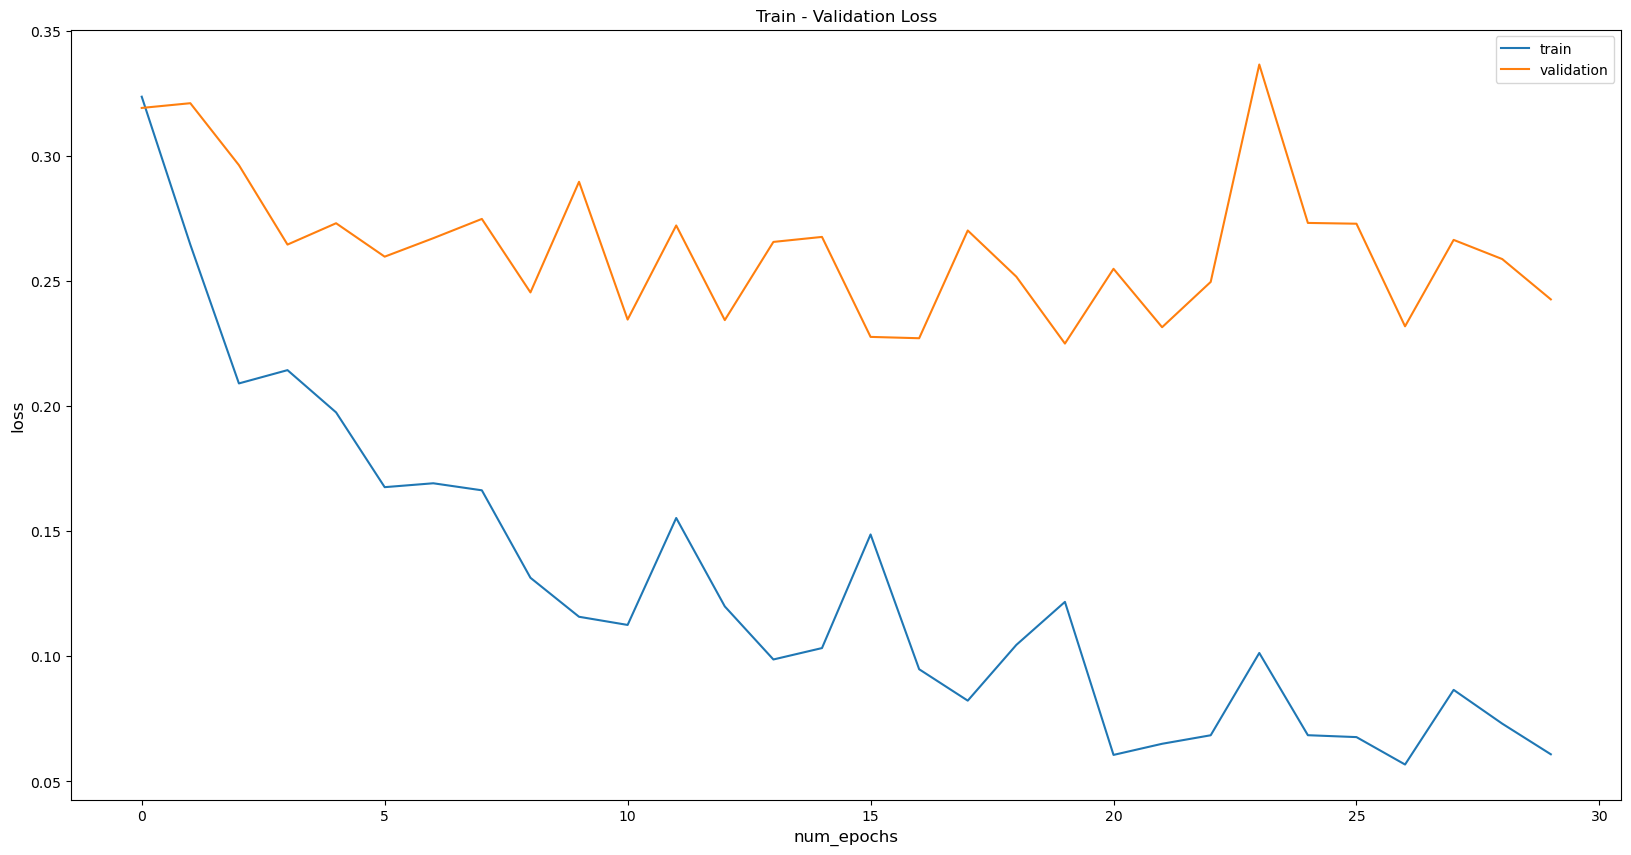

In [36]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

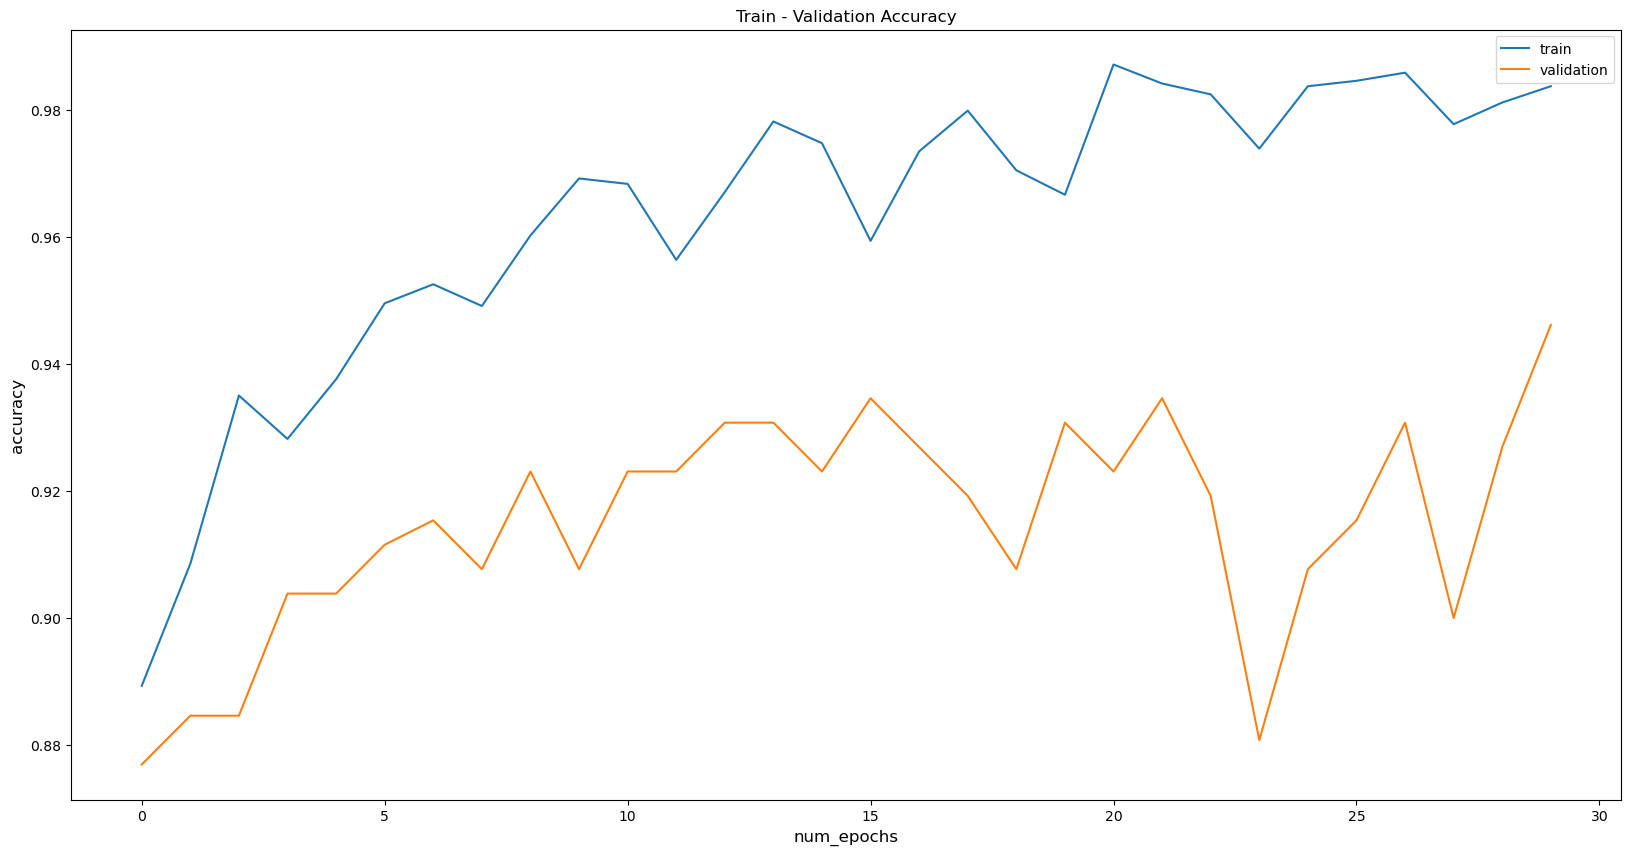

In [37]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

## Confusion matrix

In [38]:
predicted_y_valid = []
for p in preds:
    predicted_y_valid.append(p.item())

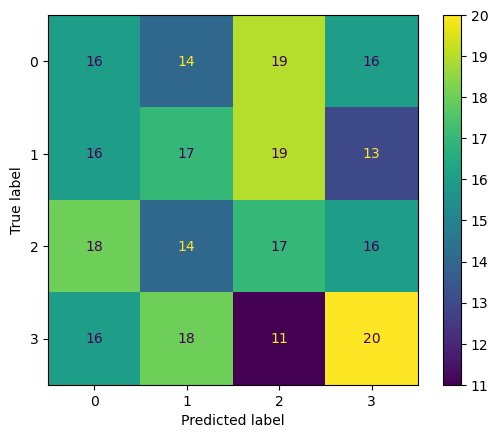

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(df.iloc[val_indices]['Label'].tolist(), predicted_y_valid[-260:])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Captum

In [40]:
sample_image = None
sample_label = None
for test_images, test_labels in train_loader:  
    sample_image = test_images[0]
    sample_label = test_labels[0]
    break

In [41]:
sample_image = sample_image.to(device)
input = sample_image.unsqueeze(0)
output = resnet(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

# print(pred_label_idx, prediction_score)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')', sample_label)

Predicted: tensor(1, device='cuda:0') ( 0.9996258020401001 ) tensor(1)


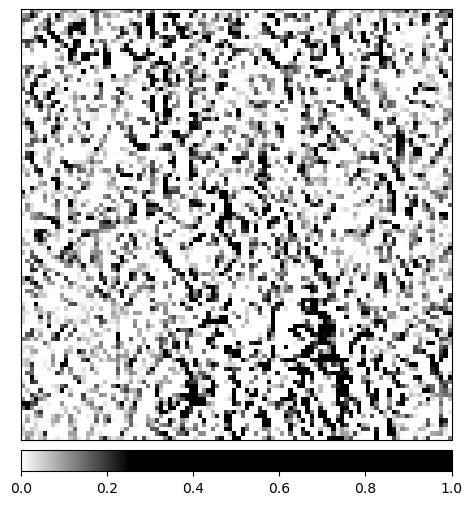

In [42]:
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

integrated_gradients = IntegratedGradients(resnet)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

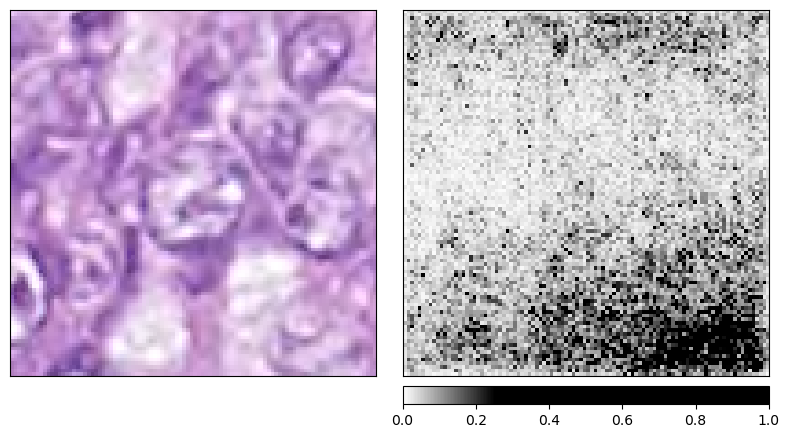

In [43]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(sample_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


# Submission

In [44]:
arr = os.listdir(BASE_PATH + 'test/')
test_df = pd.DataFrame()
test_df['Filename'] = arr
test_df['Label'] = 0
dataset = Colon_Cancer_Dataset(test_df,BASE_PATH + 'test/', transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32)

In [45]:
model = resnet

In [46]:
preds = []
with torch.no_grad():
    for img, label in test_loader:
        inputs, labels = img.to(device), label.to(device)
#         outputs = best_trained_model(inputs)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted)

In [47]:
predsList = [p.item() for p in preds]
test_df['Label'] = predsList

In [48]:
 test_df.to_csv('submission.csv', index=False)